In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [2]:
b_size=32
transform = transforms.Compose([
    transforms.Resize(size=(32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,.5,.5), (0.5,.5,.5))
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=b_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=b_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:

# classes = [0,1,2,3,4,5,6,7,8,9]

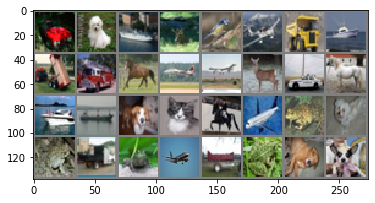

In [4]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import pdb

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 6, 5)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)#nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv2_2 = nn.Conv2d(6, 16, 5)
        self.conv2_2_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.conv3_bn = nn.BatchNorm2d(120)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
#         pdb.set_trace()
        x = self.pool(F.relu(self.conv1(x)))
#         pdb.set_trace()
        x1= self.pool(F.relu(self.conv2_2_bn(self.conv2_2(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        
        x+=x1
#         pdb.set_trace()
        x = self.dropout(x)
#         pdb.set_trace()
        x = x.view(-1, 16 * 5 * 5)
#         pdb.set_trace()
        x = F.relu(self.fc1_bn(self.fc1(x)))
#         x = F.relu(self.fc2(x))
        x = self.dropout(F.relu(self.fc2_bn(self.fc2(x))))
#         pdb.set_trace()
        x = self.softmax(self.fc3(x))
        return x


model = Net()

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
model.to(device)



Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (conv3_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc2_bn): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_feature

In [6]:
import torch.optim as optim

# specify loss function
criterion = torch.nn.CrossEntropyLoss()
learning_rate1=8e-3
# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr =learning_rate1, momentum= 0.95,weight_decay=0.0)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=0)

In [7]:
# number of epochs to train the model
import pdb
n_epochs = 50 # you may increase this number to train a final model
import pdb
test_loss_s = np.Inf # track change in validation loss

tr_loss_hist=[]
test_loss_hist=[]
correct = 0
total = 0
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    test_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
 ############# TESTING ##############
    model.eval()
    with torch.no_grad():
         for data, target in test_loader:
             data, target = data.to(device), target.to(device)
             output = model(data)
             loss = criterion(output, target)
             test_loss += loss.item()*data.size(0)
             _, pred = torch.max(output, 1)    
             total += target.size(0)
             correct += (pred == target).sum().item()
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    tr_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    

    print('Epoch: {} \tTraining Loss: {:.6f} \tTesting Accuracy: {:.6f}'.format(
        epoch, train_loss, np.sum(correct)/np.sum(total)))
    
    # save model if validation loss has dropped
    if test_loss <= test_loss_s:
        print('Test loss dropped ({:.6f} --> {:.6f}).  Saving model ...'.format(
        test_loss_s,
        test_loss))
        torch.save(model.state_dict(), 'model_mnist_1e_3.pt')
        test_loss_s = test_loss

Epoch: 1 	Training Loss: 1.561724 	Testing Accuracy: 0.519700
Test loss dropped (inf --> 1.308414).  Saving model ...
Epoch: 2 	Training Loss: 1.320817 	Testing Accuracy: 0.553950
Test loss dropped (1.308414 --> 1.139374).  Saving model ...
Epoch: 3 	Training Loss: 1.215823 	Testing Accuracy: 0.576600
Test loss dropped (1.139374 --> 1.069018).  Saving model ...
Epoch: 4 	Training Loss: 1.144720 	Testing Accuracy: 0.592400
Test loss dropped (1.069018 --> 1.014459).  Saving model ...
Epoch: 5 	Training Loss: 1.089333 	Testing Accuracy: 0.605620
Test loss dropped (1.014459 --> 0.973520).  Saving model ...
Epoch: 6 	Training Loss: 1.055212 	Testing Accuracy: 0.615333
Test loss dropped (0.973520 --> 0.963089).  Saving model ...
Epoch: 7 	Training Loss: 1.019913 	Testing Accuracy: 0.622414
Test loss dropped (0.963089 --> 0.951180).  Saving model ...
Epoch: 8 	Training Loss: 0.990532 	Testing Accuracy: 0.629313
Test loss dropped (0.951180 --> 0.912239).  Saving model ...
Epoch: 9 	Training Lo

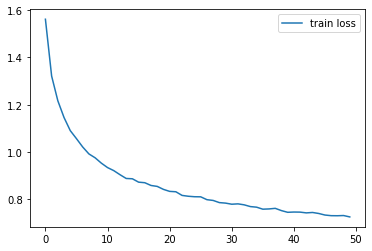

In [8]:
import matplotlib.pyplot as plt
plt.plot(tr_loss_hist,label='train loss')
# plt.plot(val_loss_hist,label='validation loss')
plt.savefig('lr_3.png',dip=200)
plt.legend()

In [9]:


train_loss = 0.0

correct = 0
total = 0
model.eval()
i=1
# iterate over test data
len(test_loader)
with torch.no_grad():
    for data, target in train_loader:
        data, target = data.cuda(5), target.cuda(5)
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)    
        total += target.size(0)
        correct += (pred == target).sum().item()

        
# average test loss
train_loss = train_loss/len(train_loader.dataset)
print('Train Loss: {:.6f}\n'.format(train_loss))

print('\nTrain Accuracy: %2d%% (%2d/%2d)' % (
    100. * np.sum(correct) / np.sum(total),
    np.sum(correct), np.sum(total)))

Train Loss: 0.458413


Train Accuracy: 84% (42420/50000)


In [10]:


test_loss = 0.0

correct = 0
total = 0
train_on_gpu=True
model.eval()
i=1
# iterate over test data
len(test_loader)
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(5), target.cuda(5)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)    
        total += target.size(0)
        correct += (pred == target).sum().item()

        
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    100. * np.sum(correct) / np.sum(total),
    np.sum(correct), np.sum(total)))

Test Loss: 0.818953


Test Accuracy: 72% (7216/10000)
